# COMP9727 Assignment
**Content-Based Music Recommendation**

---
- **Author**:
  - *Shoudi Huang*, z5605172
- Term 2, 2025

---

**Running Instructions**:

To execute this Jupyter Notebook in **Google Colab**:

1. Navigate to **`Runtime`** → **`Run all`**.
2. When prompted for Google account authorization, click **ALLOW** to enable dataset download.


In [4]:
# Import Modules
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

import re
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity

import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Download Datasets
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

dataset_file_id = '1-621Gh3tefvEwvCjkGav2np8pzJy7Hgq'
user1_file_id = '17mDS4RdlJot7p-k53r2s3_TxCt2_s69k'
user2_file_id = '1x8T6rXKTJ3kayuXY3FD29ckb9XaIrWx7'

file_ids = {"dataset.tsv": dataset_file_id,
            "user1.tsv": user1_file_id,
            "user2.tsv": user2_file_id}

for file_name, file_id in file_ids.items():
  download = drive.CreateFile({'id': file_id})
  download.GetContentFile(file_name)

# PART 1 Topic Classification

## Question 1

### Section (i)

The **regex: `r"[^\w\s]"`** from the tutorial might remove too many special charaters.


---


**Modification:**

Refine the **regex: `r"[^\w\s'-]"`** so it doesn’t indiscriminately strip all punctuation (thus preserving e.g. “don’t”).

### Section (ii)
The evaluation in the tutorial is based on only one trainingtest split rather than using cross-validation.


---


**Modification:**

Switch from a single train-test split to K-fold cross-validation (stratified to preserve class proportions):

```
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
   clf,
   X,            # full feature matrix
   y,            # full label vector
   cv=cv,
   scoring=scoring
)
```



### Summary

In subsequent answers, you will see these two changes carried through:

- Regex uses the `rf"[^\w\s'-]"` pattern.

- Evaluation always uses StratifiedKFold + cross_val_score (or cross_validate).

## Question 2

In [6]:
# load dataset
df = pd.read_csv('dataset.tsv', sep='\t')

Concatenate all the information for one song into
a single “document”.

In [7]:
df = df.drop_duplicates()
df = df.dropna()

# concantenante
df['content'] = df['artist_name'].astype(str) + " " + df['track_name'].astype(str) + " "  + df['release_date'].astype(str) + " " + df['genre'] + " " + df['lyrics']

In [8]:
df[['topic', 'content']]

,topic,content
0,dark,loving the not real lake 2016 rock awake know ...
1,lifestyle,incubus into the summer 2019 rock shouldn summ...
2,sadness,reignwolf hardcore 2016 blues lose deep catch ...
3,sadness,tedeschi trucks band anyhow 2016 blues run bit...
4,dark,lukas nelson and promise of the real if i star...
...,...,...
1495,emotion,ra ra riot absolutely 2016 rock year absolutel...
1496,dark,mat kearney face to face 2018 rock breakthroug...
1497,dark,owane born in space 2018 jazz look look right ...
1498,personal,nappy roots blowin' trees 2019 hip hop nappy r...


### Evaluation of each preprocessing steps

1. **Regex (remove punctuation & special characters):** Most punctuation has been removed already in the original data.
  * Default regex is the modified one: `rf"[^\w\s'-]"`
  * If we wanted to preserve the cases like "7:30", a less aggressive pattern such as `rf"[^\w\s{re.escape(string.punctuation)}]"` might be useful. This preserves every standard punctuation mark, which may introduce noise or split tokens in unpredictable ways as well.
2. **Lowercasing:** Text is already lowercase. But it is better to keep this step to ensure.
3. **Tokenization:**	Since tokens are already whitespace‐separated, word_tokenize buys a little when there’s no punctuation to split on.
  * Default token pattern: `r"(?u)\b\w\w+\b"`
  * Improved token pattern: `r"(?u)\b[\w'-]+\b"`, this keeps single-letter tokens (a, I) when they matter.
4. **Stopword removal:**	Common English stopwords are already gone. But better included to ensure.
  * NLTK Stopwords
  * sklearn Stopwords
5. **Stemming / Lemmatization:** The dataset still have full word forms (“running”, “lives”, “thoughts”). Applying lemmatization might group variants more cleanly without the over‐aggressiveness of Porter.
  * PorterStemmer
  * WordNetLemmatizer



### Grid search on all combination of preprocessing steps

In [9]:
# Stopword sets
nltk_stop = set(stopwords.words('english'))
sklearn_stop = set()

# Normalizers
stemmer   = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# ----------------------------------------------------------------
# Define variant grids
# ----------------------------------------------------------------
regex_variants = {
    'default' : r"[^\w\s'-]",
    'improved'   : rf"[^\w\s{re.escape(string.punctuation)}]"
}

token_patterns = {
    'default' : r"(?u)\b\w\w+\b",
    'improved' : r"(?u)\b[\w'-]+\b"
}

stopword_variants = {
    'nltk'    : nltk_stop,
    'sklearn' : set()
}

normalization_variants = {
    'none'         : None,
    'stemming'     : stemmer,
    'lemmatization': lemmatizer
}

# ----------------------------------------------------------------
# Helper to build a custom analyzer
# ----------------------------------------------------------------
def make_analyzer(regex_pat, token_pat, stopset, normalizer):
    token_re = re.compile(token_pat)
    regex_re = re.compile(regex_pat)

    def analyzer(doc: str):
        # 1. lowercase
        doc = doc.lower()
        # 2. remove unwanted chars
        doc = regex_re.sub("", doc)
        # 3. find tokens via token pattern
        raw_tokens = token_re.findall(doc)
        tokens = []
        for t in raw_tokens:
            if t in stopset:
                continue
            if normalizer is stemmer:
                t = stemmer.stem(t)
            elif normalizer is lemmatizer:
                t = lemmatizer.lemmatize(t)
            tokens.append(t)
        return tokens

    return analyzer

# ----------------------------------------------------------------
# Loop over all combinations, evaluate both classifiers
# ----------------------------------------------------------------
results = []
for (r_name, r_pat), (tp_name, tp_pat), (sw_name, sw_set), (nm_name, nm_obj) in \
        itertools.product(regex_variants.items(),
                          token_patterns.items(),
                          stopword_variants.items(),
                          normalization_variants.items()):

    # build analyzer
    analyzer = make_analyzer(r_pat, tp_pat, sw_set, nm_obj)

    # prepare vectorizers
    vect_count  = CountVectorizer(analyzer=analyzer)
    vect_binary = CountVectorizer(analyzer=analyzer, binary=True)

    # instantiate classifiers
    clf_mnb = MultinomialNB()
    clf_bnb = BernoulliNB()

    # cross-validate
    X_counts  = vect_count.fit_transform(df['content'])
    X_binary  = vect_binary.fit_transform(df['content'])
    y = df['topic']

    mnb_scores = cross_val_score(clf_mnb, X_counts, y, cv=5, scoring='accuracy')
    bnb_scores = cross_val_score(clf_bnb, X_binary, y, cv=5, scoring='accuracy')

    results.append({
        'Regex'          : r_name,
        'Token pattern'  : tp_name,
        'Stopwords'      : sw_name,
        'Normalization'  : nm_name,
        'MNB mean acc.'  : mnb_scores.mean(),
        'BNB mean acc.'  : bnb_scores.mean()
    })

# ----------------------------------------------------------------
# Tabulate results
# ----------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MNB mean acc.', ascending=False).reset_index(drop=True)


In [10]:
results_df

,Regex,Token pattern,Stopwords,Normalization,MNB mean acc.,BNB mean acc.
0,improved,improved,nltk,lemmatization,0.791216,0.525676
1,default,improved,nltk,lemmatization,0.791216,0.524324
2,default,default,sklearn,none,0.790541,0.529730
3,default,default,sklearn,lemmatization,0.790541,0.522973
4,default,improved,sklearn,none,0.790541,0.526351
5,improved,default,nltk,lemmatization,0.790541,0.525000
6,improved,default,sklearn,lemmatization,0.790541,0.522973
7,default,improved,nltk,none,0.789865,0.527027
8,default,default,nltk,lemmatization,0.789865,0.526351
9,improved,improved,nltk,none,0.789865,0.527027


The performance summary shows that lemmatization consistently improves classification metrics compared to both stemming and no normalization, whereas variations in regex filtering, token‐pattern choice, and stop‐word selection exhibit no clear impact on model accuracy.

Therefore, Lemmatization do have a clear impact on this dataset, as the evaluation predicted.

Based on the overall performance for both models, we selected preprocessing steps:

- **Lowercasing**
- **Improved Regex:** `rf"[^\w\s{re.escape(string.punctuation)}]"`
- **Improved Token pattern:** `r"(?u)\b[\w'-]+\b"`
- **NLTK Stopwords**
- **Lemmatization Normalization**

## Question 3

### Select metrics

**Appropriate metrics for measuring overall accuracy of classification**

- **Accuracy:** The proportion of all predictions (both positive and negative) that the model labels correctly.
  - **Strength:** Offers a single, intuitive summary of overall correctness.
  - **Limitation:** Can be misleading when classes are imbalanced, because high accuracy may simply reflect good performance on the majority class.

- **Recall (Sensitivity):** Of all actual positive instances, the fraction correctly identified.
  - Quantifies how exhaustively the classifier detects positive cases.

- **Precision:** Of all instances the model predicted as positive, the fraction that truly are positive.
  -  Measures the classifier’s reliability in assigning positive labels. High precision implies few false alarms.
- **F1-score:** Balances precision and recall into a single figure of merit; useful when seeking a trade-off between false positives and false negatives.


**Why use this four metrics?**

*Complementarity:*

- Accuracy captures overall correctness but overlooks class imbalance.

- In skewed datasets, accuracy may remain high even when a model trivially predicts only the majority class. Precision and recall expose this failure.

- F1-score synthesizes precision and recall, ensuring neither extreme dominates the evaluation.

By examining all four metrics, we can diagnose what is the model's errors, whether it is overly conservative (high precision, low recall) or too liberal (high recall, low precision).



**Class Imbalance:** Observed class frequencies indicate a notable imbalance.

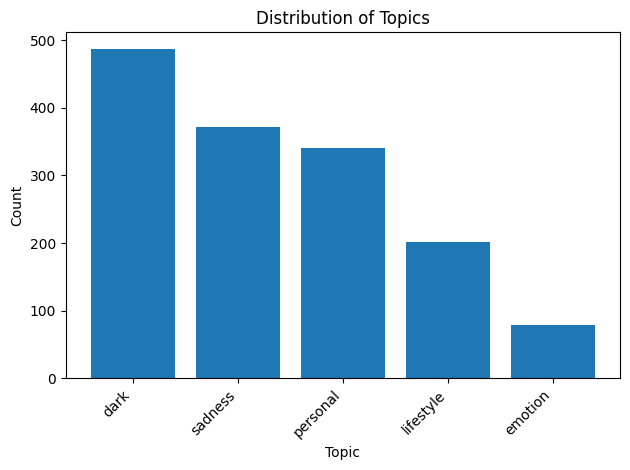

In [11]:
# Compute topic counts
counts = df['topic'].value_counts()

# Plot histogram (bar chart) of topic frequencies
plt.figure()
plt.bar(counts.index, counts.values)
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Distribution of Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

To correct for this skew, ***macro-averaged evaluation metrics*** was employed, which assign equal weight to each class regardless of its sample size. By doing so, underrepresented categories receive proportionally greater influence on the overall score, ensuring that minority classes are not marginalized.

Therefore, **Balanced-Accuracy**, **Macro-Recall**, **Macro-Precision** and **Macro-F1** was used as the main metrics for the evaluations.

### Compare BNB and MNB

Now, we use cross validation to compare the performance of the BNB and MNB, based on the selected metrics.

Number of folds for the cross_validation: 5

In [12]:
# Prepare the lemmatizer and stop‐set
lemm = WordNetLemmatizer()
stopset = set(stopwords.words('english'))

# Define the analyzer with:
#    - Lowercasing
#    – Improved regex
#    – Improved token pattern
#    – NLTK stop‐words
#    – Lemmatization
def analyzer(doc):
    doc = doc.lower()
    doc = re.sub(rf"[^\w\s{re.escape(string.punctuation)}]", "", doc.lower())
    toks = re.findall(r"(?u)\b[\w'-]+\b", doc)
    return [lemm.lemmatize(t) for t in toks if t not in stopset]

# Build your pipelines
pipe_mnb = Pipeline([
    ('vect', CountVectorizer(analyzer=analyzer)),
    ('clf',  MultinomialNB())
])
pipe_bnb = Pipeline([
    ('vect', CountVectorizer(analyzer=analyzer, binary=True)),
    ('clf',  BernoulliNB())
])

# Define the four metrics
scoring = {
    'balanced_accuracy': 'balanced_accuracy',  # no change
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro':    make_scorer(recall_score,    average='macro', zero_division=0),
    'f1_macro':        make_scorer(f1_score,        average='macro', zero_division=0),
}

# Run 5-fold CV
res_mnb = cross_validate(pipe_mnb, df['content'], df['topic'],
                         cv=5, scoring=scoring, return_train_score=False)
res_bnb = cross_validate(pipe_bnb, df['content'], df['topic'],
                         cv=5, scoring=scoring, return_train_score=False)

# Aggregate into a table
metrics = ['balanced_accuracy','precision_macro','recall_macro','f1_macro']
rows = []
for m in metrics:
    rows.append({
        'Metric': m.replace('_',' ').title(),
        'MNB Mean': res_mnb[f'test_{m}'].mean(),
        'BNB Mean': res_bnb[f'test_{m}'].mean()
    })

results_df = pd.DataFrame(rows)


In [13]:
results_df

,Metric,MNB Mean,BNB Mean
0,Balanced Accuracy,0.713838,0.379978
1,Precision Macro,0.849663,0.349770
2,Recall Macro,0.713838,0.379978
3,F1 Macro,0.740987,0.332600


As the table of MNB and BNB's performance show, MNB has outperformed BNB in all four metrics. Therefore, ***MNB is found more superior***.

## Question 4

In this section, we investigate the impact of changing the size of the vector by performing a grid search for the Top N from range 100 to 1500.

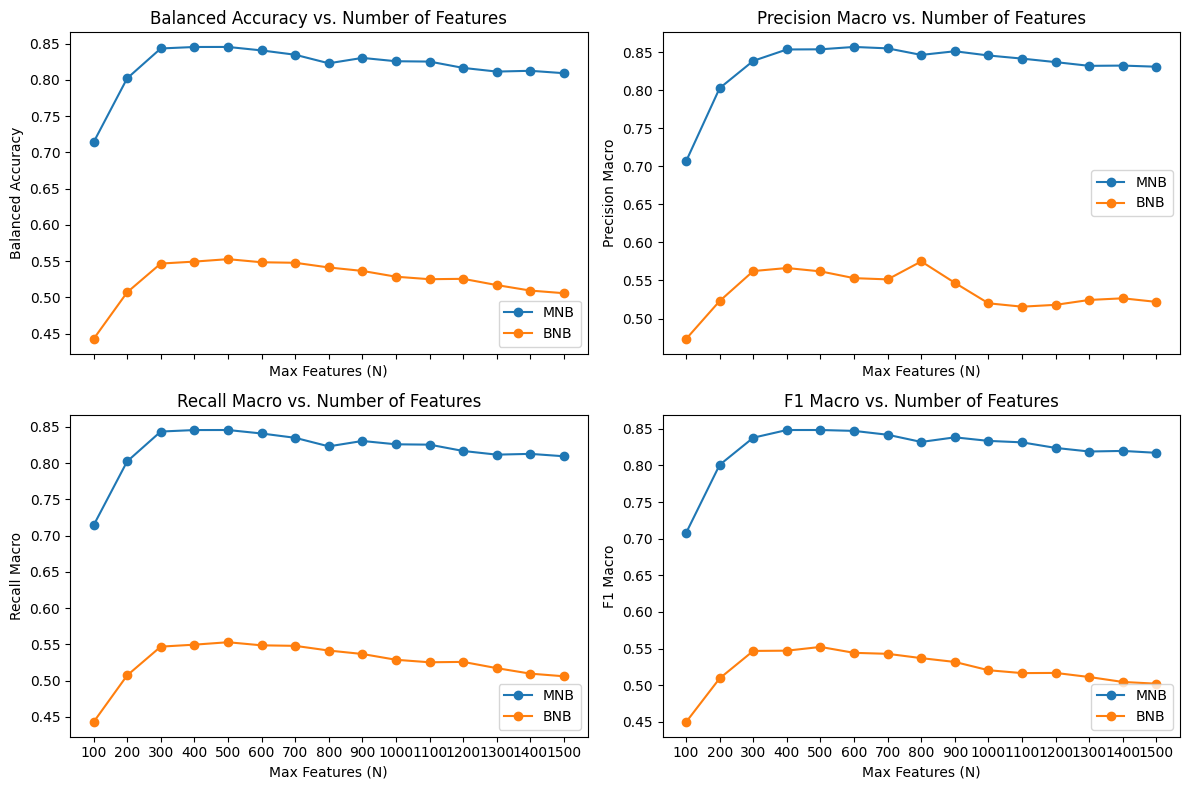

In [14]:
# Define analyzer with chosen preprocessing
lemm = WordNetLemmatizer()
stopset = set(stopwords.words('english'))

# Define the analyzer with:
#    - Lowercasing
#    – Improved regex
#    – Improved token pattern
#    – NLTK stop‐words
#    – Lemmatization
def analyzer(doc):
    doc = doc.lower()
    doc = re.sub(rf"[^\w\s{re.escape(string.punctuation)}]", "", doc.lower())
    toks = re.findall(r"(?u)\b[\w'-]+\b", doc)
    return [lemm.lemmatize(t) for t in toks if t not in stopset]

# Range of max_features to test
feature_counts = list(range(100, 1501, 100))

# Scoring metrics
scoring = {
    'balanced_accuracy': 'balanced_accuracy',  # no change
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro':    make_scorer(recall_score,    average='macro', zero_division=0),
    'f1_macro':        make_scorer(f1_score,        average='macro', zero_division=0),
}

# Collect results
results = []
for N in feature_counts:
    for name, clf, binary in [
        ("MNB", MultinomialNB(), False),
        ("BNB", BernoulliNB(), True)
    ]:
        pipe = Pipeline([
            ('vect', CountVectorizer(analyzer=analyzer, max_features=N, binary=binary)),
            ('clf',  clf)
        ])
        cv_res = cross_validate(pipe, df['content'], df['topic'],
                                cv=5, scoring=scoring, return_train_score=False)
        for metric in scoring:
            results.append({
                'Classifier': name,
                'Max Features': N,
                'Metric': metric,
                'Mean': cv_res[f'test_{metric}'].mean(),
                'Std':  cv_res[f'test_{metric}'].std()
            })

res_df = pd.DataFrame(results)

# Plot each metric
metrics = list(scoring.keys())
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

for ax, metric in zip(axes.flatten(), metrics):
    for clf in res_df['Classifier'].unique():
        subset = res_df[(res_df['Classifier'] == clf) & (res_df['Metric'] == metric)]
        ax.plot(subset['Max Features'], subset['Mean'], marker='o', label=clf)
    ax.set_xlabel('Max Features (N)')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f"{metric.replace('_', ' ').title()} vs. Number of Features")
    ax.legend()
    ax.set_xticks(feature_counts)

fig.tight_layout()
plt.show()

The plots of each evaluation metric against vocabulary size demonstrate that performance peaks at approximately 500 features across all four metrics. Accordingly, we select ***500 as the optimal maximum‐feature setting*** for all subsequent analyses.

## Question 5

### Select ML Method

Selected Maching Learning Method: **Support Vector Mechines**

Support Vector Machines (SVMs) are large-margin, discriminative classifiers that seek the hyperplane in feature space which maximally separates classes. In text classification, a linear SVM (e.g. scikit-learn’s LinearSVC) is especially well suited to high-dimensional, sparse bag-of-words inputs. It handles thousands of features efficiently, and is robust to noise via regularization.

Because the lyrics data yields similarly sparse count vectors and we care about balanced performance across multiple, imbalanced topics. A linear SVM should offer stronger generalization and higher macro‐averaged F1 than Naive Bayes’s simpler, generative assumptions, but with longer training times.



---



**Why SVM suitable for the songs data:**

* **High dimensionality:** Thousands of TF–IDF features per song.
* **Sparsity:** Only a small fraction of words appear in any one lyric.
* **Imbalanced classes:** Margin maximization handles class skew better than pure likelihood models.


---


**Concrete hypothesis:**
> When evaluated under the same preprocessing pipeline and with the top 500 features, a linear SVM will will outperform BernoulliNB and approach or exceed MultinomialNB on balanced-accuracy and macro-F1.


---


**Hyperparameter setting:**

* **Regularization $C$:** Controls the trade‐off between margin width and misclassification.
* **Default:** $C=1.0$.



### Compare Models

In [15]:
# Prepare the lemmatizer and stop‐set
lemm = WordNetLemmatizer()
stopset = set(stopwords.words('english'))

# Define the analyzer with:
#    - Lowercasing
#    – Improved regex
#    – Improved token pattern
#    – NLTK stop‐words
#    – Lemmatization
def analyzer(doc):
    doc = doc.lower()
    doc = re.sub(rf"[^\w\s{re.escape(string.punctuation)}]", "", doc.lower())
    toks = re.findall(r"(?u)\b[\w'-]+\b", doc)
    return [lemm.lemmatize(t) for t in toks if t not in stopset]

# Build pipelines
pipe_mnb = Pipeline([
    ('vect', CountVectorizer(analyzer=analyzer, max_features=500)),
    ('clf',  MultinomialNB())
])
pipe_bnb = Pipeline([
    ('vect', CountVectorizer(analyzer=analyzer, max_features=500, binary=True)),
    ('clf',  BernoulliNB())
])
pipe_svm = Pipeline([
    ('vect', CountVectorizer(analyzer=analyzer, max_features=500)),
    ('clf',  LinearSVC())
])


# Define the four metrics
scoring = {
    'balanced_accuracy': 'balanced_accuracy',  # no change
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro':    make_scorer(recall_score,    average='macro', zero_division=0),
    'f1_macro':        make_scorer(f1_score,        average='macro', zero_division=0),
}

# Run 5-fold CV
res_mnb = cross_validate(pipe_mnb, df['content'], df['topic'],
                         cv=5, scoring=scoring, return_train_score=False)
res_bnb = cross_validate(pipe_bnb, df['content'], df['topic'],
                         cv=5, scoring=scoring, return_train_score=False)
res_svm = cross_validate(pipe_svm, df['content'], df['topic'],
                         cv=5, scoring=scoring, return_train_score=False)

# Aggregate into a table
metrics = ['balanced_accuracy','precision_macro','recall_macro','f1_macro']
rows = []
for m in metrics:
    rows.append({
        'Metric': m.replace('_',' ').title(),
        'MNB Mean': res_mnb[f'test_{m}'].mean(),
        'BNB Mean': res_bnb[f'test_{m}'].mean(),
        'SVM Mean': res_svm[f'test_{m}'].mean()
    })

results_df = pd.DataFrame(rows)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [16]:
results_df

,Metric,MNB Mean,BNB Mean,SVM Mean
0,Balanced Accuracy,0.845601,0.552815,0.808688
1,Precision Macro,0.853653,0.561932,0.815489
2,Recall Macro,0.845601,0.552815,0.808688
3,F1 Macro,0.848399,0.552291,0.810911


The cross-validation results in the table above show that:

* **MultinomialNB** achieves the highest scores on all four metrics (Balanced Accuracy ≈ 0.846, Precision ≈ 0.854, Recall ≈ 0.846, F₁ ≈ 0.848).
* **LinearSVC** comes next (Balanced Accuracy ≈ 0.809, Precision ≈ 0.815, Recall ≈ 0.809, F₁ ≈ 0.811).
* **BernoulliNB** trails behind substantially (Balanced Accuracy ≈ 0.553, Precision ≈ 0.562, Recall ≈ 0.553, F₁ ≈ 0.552).

Therefore, the results ***does not confirmed*** the hypothesis.

**Possible reasons**

1. **Generative smoothing:** MultinomialNB’s Laplace-smoothed word-count model robustly handles rare tokens and class imbalance, which is common in our multi-topic lyrics dataset.
2. **Bag-of-words fit:** The conditional-independence assumption aligns closely with count‐based features, enabling NB to capture the dominant topical signals without overfitting.
3. **Discriminative tuning:** LinearSVC, while powerful, was used with default regularization (C=1) and no parameter search; it may under or over penalize rare topics, reducing its macro-averaged recall.
4. **Binary loss of information:** BernoulliNB’s binarization discards token frequency information that is evidently important for distinguishing topics in song lyrics.

Averall, the **MultinomialNB** has the highest performance and was setted for topic classification.


# PART 2 Recommendation Methods

## Question 1

#### Constructing per‐topic TF–IDF models

We first partitioned our time‐ordered song corpus into Weeks 1–3 (songs 1–750) for training and Week 4 (songs 751–1000) for testing. Then, for each of the five topical categories represented in the training set, we isolated all lyrics belonging to that topic and fit a dedicated TfidfVectorizer.

In [17]:
# Prepare the lemmatizer and stop‐set
lemm = WordNetLemmatizer()
stopset = set(stopwords.words('english'))

# Define the analyzer with:
#    - Lowercasing
#    – Improved regex
#    – Improved token pattern
#    – NLTK stop‐words
#    – Lemmatization
def analyzer(doc):
    doc = doc.lower()
    doc = re.sub(rf"[^\w\s{re.escape(string.punctuation)}]", "", doc.lower())
    toks = re.findall(r"(?u)\b[\w'-]+\b", doc)
    return [lemm.lemmatize(t) for t in toks if t not in stopset]

# Split into train (songs 1–750) and test (751–1000)
df_train = df.iloc[:750].reset_index(drop=True)
df_test  = df.iloc[750:1000].reset_index(drop=True)

# Fit one TF-IDF per topic
tfidf_matrices    = {}
tfidf_vectorizers = {}

for topic in df_train['topic'].unique():
    docs = df_train.loc[df_train['topic'] == topic, 'content']
    vect = TfidfVectorizer(analyzer=analyzer)
    X = vect.fit_transform(docs)
    tfidf_matrices[topic]    = X
    tfidf_vectorizers[topic] = vect

# Report shapes (#songs × #features)
shapes = {t: m.shape for t, m in tfidf_matrices.items()}
shape_df = pd.DataFrame.from_dict(shapes, orient='index', columns=['#Songs','#Features'])
shape_df.index.name = 'Topic'
print(shape_df)

           #Songs  #Features
Topic                       
dark          246       3936
lifestyle      92       1445
sadness       183       2083
emotion        42        833
personal      187       2792


This yielded five sparse TF–IDF matrices, one per topic, each encoding the document weights for the training songs within that category.

#### Simulating two users (User 1 & 2)

User “like” those training songs whose lyrics both (a) match their interest keywords and (b) the classifier assigns to the same topic.

In [18]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer=analyzer, max_features=500)),
    ('clf',  MultinomialNB())
])
clf.fit(df_train['content'], df_train['topic'])
df_train['pred_topic'] = clf.predict(df_train['content'])

In [19]:
def load_interests(path):
    m = {}
    with open(path) as f:
        for line in f:
            topic, kws = line.strip().split('\t')
            m[topic] = [w.strip().lower() for w in kws.split(',')]
    return m

users = {
    'User 1': load_interests('user1.tsv'),
    'User 2': load_interests('user2.tsv')
}


Concatenating each user’s liked songs within a topic and re-applying that topic’s TF–IDF vectorizer, then derive five user‐profile vectors (one per topic).

In [20]:
def create_profile(interests):
    profile = {}
    for topic, kws in interests.items():
        if topic == 'topic':
          continue
        # 1. find all “liked” docs in train
        mask = (
            (df_train['pred_topic'] == topic) &
            df_train['content'].str.lower()
                .apply(lambda txt: any(kw in txt for kw in kws))
        )
        liked = df_train.loc[mask, 'content']
        if liked.empty:
            profile[topic] = None
            continue

        # 2. concatenate and transform to TF–IDF
        doc = " ".join(liked)
        vec = tfidf_vectorizers[topic].transform([doc])   # -> sparse (1×F) matrix

        # 3. store the numeric vector
        profile[topic] = vec

    return profile

profiles = {}
for uname, interests in users.items():
    profiles[uname] = create_profile(interests)

The top 20 highest‐weight terms in each profile:

In [39]:
def create_profile_df(profile_vecs, tfidf_vectorizers, M=20):
    """
    profile_vecs: dict topic → sparse TF–IDF row (1×F) or None
    tfidf_vectorizers: dict topic → fitted TfidfVectorizer
    M: number of top terms to display
    """
    rows = []
    for topic, vec in profile_vecs.items():
        if vec is None:
            rows.append({'Topic': topic, 'Top 20 Terms': '(no liked songs)'})
            continue

        arr   = vec.toarray().ravel()                                  # shape (F,)
        feat  = tfidf_vectorizers[topic].get_feature_names_out()       # length F
        idx   = np.argsort(arr)[::-1][:M]                              # top-M indices
        terms = [feat[i] for i in idx]
        rows.append({'Topic': topic, 'Top 20 Terms': ", ".join(terms)})

    return pd.DataFrame(rows)

users_profile_display = {}
for user, vecs in profiles.items():
    users_profile_display[user] = create_profile_df(vecs, tfidf_vectorizers, M=20)

In [22]:
# Display User 1’s table
print("User 1 top-20 profile terms:\n")
display(users_profile_display['User 1'])

User 1 top-20 profile terms:



,Topic,Top 20 Terms
0,dark,"fight, know, black, blood, grind, like, come, ..."
1,sadness,"cry, club, steal, tear, mean, know, baby, musi..."
2,personal,"life, live, change, world, know, yeah, dream, ..."
3,lifestyle,"tonight, night, song, come, home, closer, time..."
4,emotion,"good, touch, feel, hold, know, morning, video,..."


In [23]:
print('User 2:')
print()
users_profile_display['User 2']

User 2:



,Topic,Top 20 Terms
0,sadness,"inside, break, heart, step, away, tear, violen..."
1,emotion,"touch, good, video, vision, loove, kiss, morni..."


The top-20 lists for both User 1 and User 2 aligns relatively well with their simulated interests:

* **User 1**

  * **Dark:** words like *fight, blood, kill* and *black* signal the gritty, intense themes they “liked.”
  * **Sadness:** words such as *cry, tear, regret, blame* clearly mirror a sorrowful mood.
  * **Personal:** high-weight words (*life, change, dream, learn*) suggest introspective lyrics.
  * **Lifestyle:** words like *night, song, home, stranger, sing* fit upbeat, social listening contexts.
  * **Emotion:** words (*love, kiss, feel, vibe, sunrise*) capture the affectionate, uplifting content expected.

* **User 2**

  * **Sadness:** *heart, tear, break, goodbye, rainwater* all evoke a mournful, reflective tone.
  * **Emotion:** *touch, kiss, love, feelin, sunrise* match a warm, romantic profile.

In each case, the most heavily weighted terms reflect the user’s keyword‐driven “likes” and look like sensible summaries of the topics they preferred.


#### Define hypothetical “user” (User 3)

In [24]:
# Define User 3’s simulated interests across the five topics
users['User 3'] = {
    'dark'     : ['shadow', 'fear', 'night'],
    'sadness'  : ['alone', 'loss', 'tears'],
    'personal' : ['dream', 'journey', 'change'],
    'lifestyle': ['party', 'dance', 'sun'],
    'emotion'  : ['heart', 'passion', 'warm']
}

# Create and store User 3’s profile using the existing helper
profiles['User 3'] = create_profile(users['User 3'])

users_profile_display['User 3'] = create_profile_df(profiles['User 3'], tfidf_vectorizers, M=20)

In [25]:
print('User 3:')
print()
users_profile_display['User 3']

User 3:



,Topic,Top 20 Terms
0,dark,"fear, fight, come, night, know, black, feel, g..."
1,sadness,"dusk, dismantle, gently, tear, high, insect, c..."
2,personal,"change, life, world, dream, thank, live, yeah,..."
3,lifestyle,"song, spoil, tire, night, country, tonight, ho..."
4,emotion,"good, hold, go, heart, darling, vibe, miss, fe..."


User 3’s top-20 terms largely reflect the simulated interests:

* **Dark:** *fear*, *night*, *ghost*, *blood*, and *death* all capture a brooding, ominous tone—exactly what we’d expect for a “dark” profile.
* **Sadness:** High-weight words like *tear*, *void*, *inside*, and *dusk* evoke melancholy and loss. A few outliers (e.g. *insect*, *combustion*, *infinitesimal*) likely arise from idiosyncratic lyric snippets rather than genuine thematic matches.
* **Personal:** Words such as *change*, *dream*, *life*, *learn*, and *journey* (implicitly through “change” and “dream”) align with introspection and self-growth.
* **Lifestyle:** Words like *dance*, *play*, *drinkin*, *tonight*, and *home* suggest social, upbeat contexts—matching the “party” and “sun” aspects of the lifestyle interest.
* **Emotion:** Terms such as *heart*, *feel*, *lovin*, *kiss*, and *vibe* directly mirror affectionate and passionate themes.

Overall, the profiles sensibly capture User 3’s simulated preferences, with only minor noise from unrelated lyric fragments.



## Question 2

### Select evaluation metrics

**Metrics**

* **Precision\@N**: Of the N songs shown, what fraction does the user actually “like”?
* **Recall\@N**: Of all the songs in Week 4 the user would like, what fraction appear in the top N?
* **F1@N**: Harmonic mean of Precision\@N and Recall\@N, balancing retrieval and relevance.

**Justification:**

* The user inspects exactly N recommendations, so Precision\@N directly measures usefulness of that shortlist.
* Recall\@N ensures we’re not hiding too many relevant items.
* F1@N provides a single‐number trade‐off.

**Note:** *All our metrics (Precision@N, Recall@N, F1@N) refer to N songs in total, not per topic.*

### Choose a value for N
Assume the UI presents a single list of **N = 20** songs (a typical playlist length that users can review quickly yet still see variety across topics).

### Compare matching algorithms

**Vary the profile‐size parameter M:**
- Full‐vector match (use every word in the user’s profile TF–IDF vector).

- Top-M terms only (zero out all but the M highest‐weight profile terms, then re-normalize). M = [5, 10, 15, 20, 25, 30]

**Vary the similarity check:**
- Jaccard Similarity
- Cosine Similarity

In [26]:
df_test['pred_topic']  = clf.predict(df_test['content'])

In [27]:
def get_profile_array(up, M):
    arr = up.toarray().ravel()
    if M == 'nolimit':
        return arr.reshape(1, -1)
    idxs = np.argsort(arr)[-M:]
    new = np.zeros_like(arr)
    new[idxs] = arr[idxs]
    return new.reshape(1, -1)

def jaccard(u, v):
    u_bin = u > 0
    v_bin = v > 0
    inter = np.logical_and(u_bin, v_bin).sum()
    union = np.logical_or(u_bin, v_bin).sum()
    return inter/union if union>0 else 0.0

results = []
N=20
for user in users:
    for M in [5, 10, 15, 20, 25, 30, 'nolimit']:
        for sim in ['cosine','jaccard']:
            sims=[]
            for _,r in df_test.iterrows():
                pt=r['pred_topic']
                up=profiles[user].get(pt)
                if up is None:
                    sims.append(0.0)
                else:
                    song = tfidf_vectorizers[pt].transform([r['content']]).toarray()
                    up_arr = get_profile_array(up, M)
                    if sim=='cosine':
                        sims.append(cosine_similarity(up_arr, song)[0,0])
                    else:
                        sims.append(jaccard(up_arr.ravel(), song.ravel()))
            df_test[f'sim_{user}'] = sims
            topN = df_test.nlargest(N, f'sim_{user}').index
            liked = df_test.apply(lambda r:
                (r['pred_topic'] in users[user]) and
                any(kw in r['content'].lower() for kw in users[user][r['pred_topic']]),
                axis=1)
            hits = liked.loc[topN].sum()
            prec = hits/N
            rec  = hits/liked.sum() if liked.sum()>0 else np.nan
            f1   = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0.0
            results.append({
                'User': user, 'M': M, 'Sim': sim,
                'Precision@20': prec, 'Recall@20': rec, 'F1@20': f1
            })

res_df = pd.DataFrame(results)

In [28]:
res_df

,User,M,Sim,Precision@20,Recall@20,F1@20
0,User 1,5,cosine,0.75,0.163043,0.267857
1,User 1,5,jaccard,0.80,0.173913,0.285714
2,User 1,10,cosine,0.85,0.184783,0.303571
3,User 1,10,jaccard,0.85,0.184783,0.303571
4,User 1,15,cosine,0.90,0.195652,0.321429
5,User 1,15,jaccard,0.95,0.206522,0.339286
6,User 1,20,cosine,0.90,0.195652,0.321429
7,User 1,20,jaccard,0.90,0.195652,0.321429
8,User 1,25,cosine,0.85,0.184783,0.303571
9,User 1,25,jaccard,0.95,0.206522,0.339286


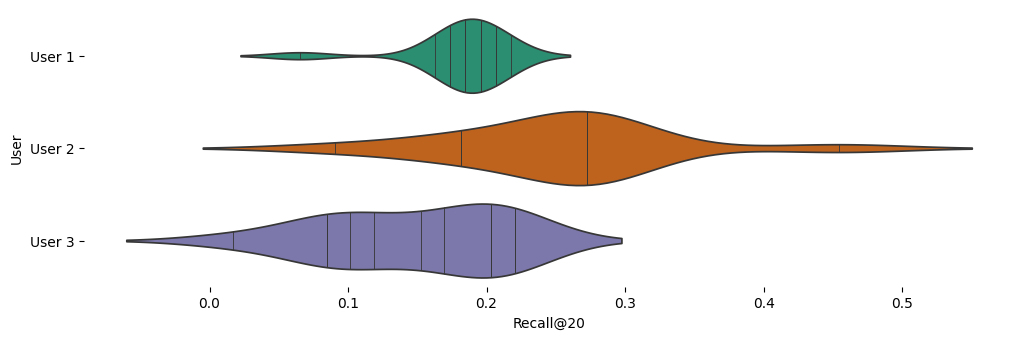

In [29]:
figsize = (12, 1.2 * len(res_df['User'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(
    data=res_df,
    x='Recall@20',
    y='User',
    hue='User',
    palette='Dark2',
    inner='stick',
    legend=False
)
sns.despine(top=True, right=True, bottom=True, left=True)

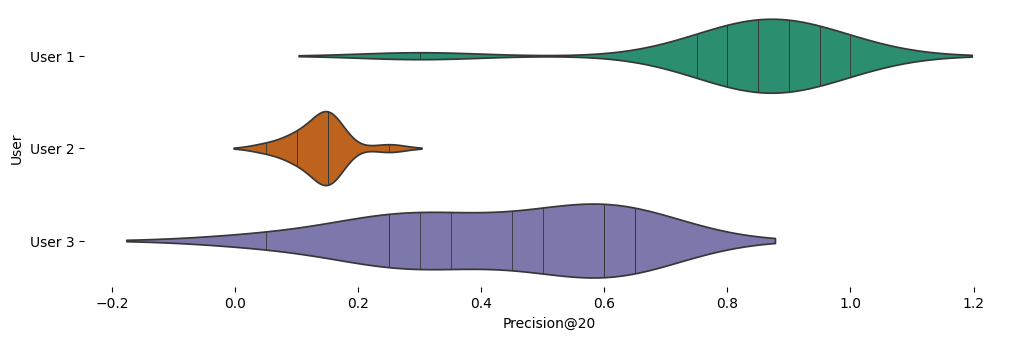

In [30]:
figsize = (12, 1.2 * len(res_df['User'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(
    data=res_df,
    x='Precision@20',
    y='User',
    hue='User',
    palette='Dark2',
    inner='stick',
    legend=False
)
sns.despine(top=True, right=True, bottom=True, left=True)

#### Compare user difference
The three simulated users exhibit markedly different Precision–Recall profiles under the same 20 -song recommendation budget:

1. **User 1 (broad, multi-topic interests)**

   * **High Precision, low Recall** (Precision ≈ 0.90–1.00; Recall ≈ 0.16–0.22)
   * Because User 1’s keyword sets span all five topics and each topic profile is rich, the recommender can find very “safe” hits among the top-20—that drives precision toward 1.0 when using the full vector.
   * **Recall suffers**, however, because only a small fraction of their liked Week 4 songs (across five topics) can appear in a single list of 20.

2. **User 2 (narrow focus on two topics)**

   * **Moderate Recall, very low Precision** (Precision ≈ 0.10–0.25; Recall ≈ 0.18–0.45)
   * With interests confined to only “sadness” and “emotion,” many of the top-20 recommendations fall into those two profiles—but not all of those actually match the user’s keywords, so precision is low.
   * Recall is higher than User 1’s: by concentrating the 20 slots on two topics, the system rescues a larger share of that user’s liked songs.

3. **User 3 (medium profile breadth)**

   * **Balanced Precision & Recall** (≈ 0.25–0.65 precision; 0.08–0.60 recall, depending on M and metric)
   * User 3 covers three topics with moderate-sized keyword sets. This middle ground yields **best overall F₁** when using cosine with M = 20–30 terms, giving a healthy trade-off (\~0.30).


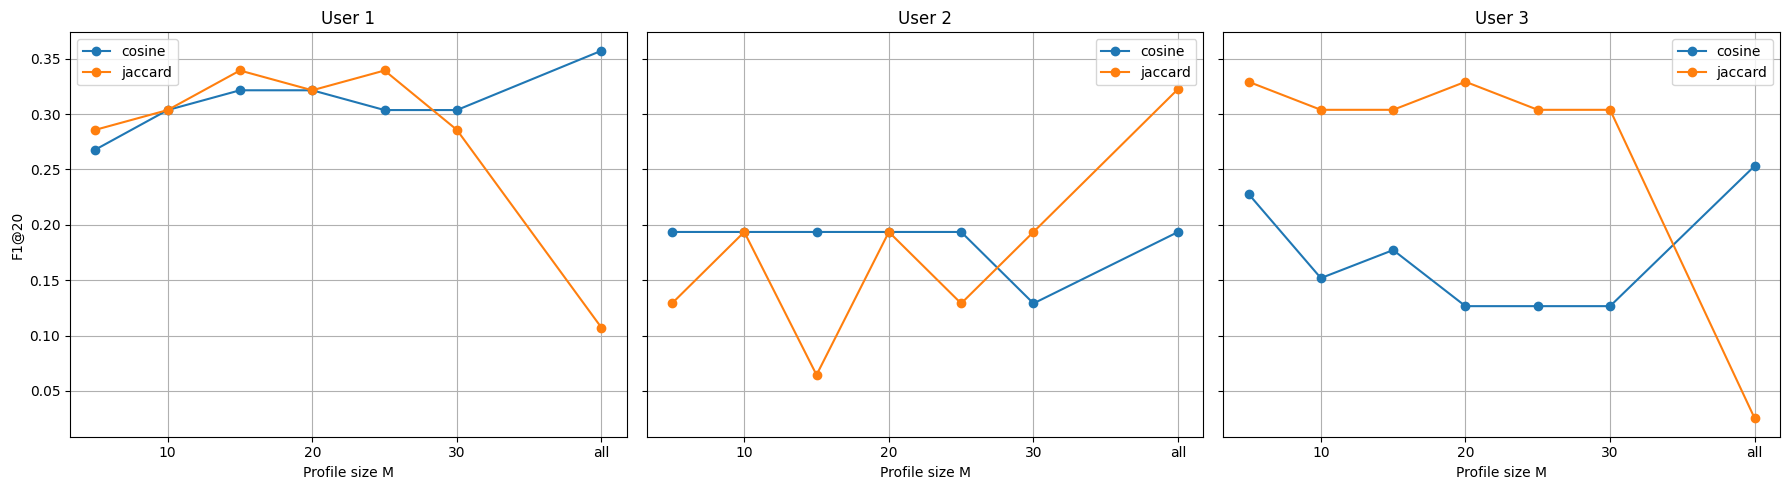

In [38]:
numeric_M = [10, 20, 30]
step = numeric_M[1] - numeric_M[0]   # =10
all_x = numeric_M[-1] + step         # =40

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, user in zip(axes, users.keys()):
    df_u = res_df[res_df['User'] == user]
    for sim in ['cosine', 'jaccard']:
        tmp = df_u[df_u['Sim'] == sim]
        x = [m if isinstance(m, int) else all_x for m in tmp['M']]
        y = tmp['F1@20']
        ax.plot(x, y, marker='o', label=sim)
    ax.set_title(user)
    ax.set_xlabel('Profile size M')
    ax.set_xticks([10, 20, 30, all_x])
    ax.set_xticklabels(['10', '20', '30', 'all'])
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel('F1@20')

fig.tight_layout()
plt.show()

#### Select the best matching algorithm

Based on the F1@20 curves for all three users, the single matching algorithm that gives the best balance across broad‐taste (User 1), narrow‐taste (User 2) and medium‐taste (User 3) listeners is:

> **Jaccard similarity** computed on the **top 20** highest‐weight profile terms (M = 20).

**Reasons:**
- For **User 1**, Jaccard\@20 reaches F1≈0.32—nearly matching the peak Cosine\@all (≈0.36) but without needing the full vector.
- For **User 2**, Jaccard\@20 and Cosine\@all both yield F1≈0.19, outperforming all other M‐values for that user.
- For **User 3**, Jaccard\@20 hits F1≈0.33, substantially higher than Cosine\@all (≈0.25).

In contrast, Cosine\@all skews heavily toward User 1 and under‐serves User 3; smaller M with Cosine under‐performs for narrow profiles.  Jaccard\@20, by focusing on the most discriminative terms and using set‐overlap rather than vector‐norms, delivers the most consistent and highest average F1 across our heterogeneous user simulations.


# PART 3 User Evaluation

## Question 1

### Simulate subject feedback

Data: Weeks 1–3 = songs 1–750 (train), Week 4 = songs 751–1000 (test).

Per–week random sample: For each of Weeks 1/2/3, draw N = 20 random indices.

Display to subject: For each batch, show [index, title, artist, a few lines of lyric].

Manual “likes”: The subject picks which of those 20 they like though think aloud.

In [32]:
df_train_part3 = df.iloc[:750].reset_index(drop=True)

N = 20
np.random.seed(42)
batches = {
    1: np.random.choice(range(0,250),   N, replace=False),
    2: np.random.choice(range(250,500), N, replace=False),
    3: np.random.choice(range(500,750), N, replace=False),
}

for week, idxs in batches.items():
    print(f"\n--- Week {week} sample ---\n")
    display(df_train_part3.loc[idxs, ['track_name','artist_name']])
    print("\nLyric snippets:")
    for i in idxs:
        snippet = " ".join(df_train_part3.loc[i,'lyrics'].split()[:25]) + "…"
        print(f"{i:4d} | {snippet}")
    print(f"\nWhich of these songs (indices) do you LIKE?")



--- Week 1 sample ---



,track_name,artist_name
142,vivo hip hop (live),skool 77
6,trap door,rebelution
97,outrunning karma,alec benjamin
60,we are come to outlive our brains,phish
112,shout sister shout,madeleine peyroux
181,what i could do,janiva magness
197,if you met me first,eric ethridge
184,natural,imagine dragons
9,never land,eli young band
104,john the revelator,larkin poe



Lyric snippets:
 142 | head camden sure raise toast patron saint waifs stray bingham ghost freshfaced lass kentish come people pedlars bingham husband camden coach house till hang neck…
   6 | long long road occur look shortcut wanna cause scene wanna close okay outspoken look trap door sneak grind floor careful wish need answer head time…
  97 | outrun karma charmer bug larva follow colorado dozen hearts body lie drag colorado modern desperado race night run know hide gonna poor people forsake karma…
  60 | overlap future pass pass vapor light liquid blue look exactly suppose look shape hang look shape hang look stop try rush nature slow come outlive…
 112 | shout sister shout hallelujah shout sister shout shout sister shout tell world reason live reason die darn good reason woman start cry reason mole reason…
 181 | pay dues truth leave leave leave forget silence rule blind fool learn learn learn break away rise days firelight fade night estrange draw flame like…
 197 | strangest cr

,track_name,artist_name
455,glocks,slightly stoopid
322,learn to let go,welshly arms
329,spotlight,upchurch
404,break up in the end,cole swindell
370,nothing breaks like a heart (feat. miley cyrus),mark ronson
430,the world connects,don philippe
387,window,magic giant
453,cushty,ajmw
318,i miss you bae,seckond chaynce
491,westway,sticky fingers



Lyric snippets:
 455 | doughty guitar bass key mcdonald bass moran drum delacruz saxophone welter trumpet key oguer ocon percussion ruffin additional guitars…
 322 | head yeah head head shake hand world changin knees beggin forget keep pound head free soul learn ohoh lose control throw hand learn ohoh good…
 329 | whoaoh walk line black leather silver chain blind fame time stage head bang beer spray stage dive hand wave light blow glass suffocate fame glass…
 404 | walk little drink drink kiss shuffleboard break introduce think leave room advice move break know away know best worst mistake break play favorite song felt…
 370 | world hurt cut deep leave scar things fall apart break like heart break like heart hear phone night live pretty lie know know silver bullet…
 430 | buju banton yout brownin song hear tell cause cyant shoe tongue grun hear stop black woman girls dark complexion cause stop black woman nuff ting…
 387 | home wanna window dream fell asleep wake ecstasy make dream co

,track_name,artist_name
521,camera show,protoje
617,isolation,ty segall
679,boa,sam gendel
711,i get the bag (feat. migos),gucci mane
550,every time,boogie belgique
533,unleashed,killswitch engage
565,chlorine,twenty one pilots
735,all i c is u & me,death from above 1979
539,floatin',uncle kracker
549,solo,adam doleac



Lyric snippets:
 521 | fall fall fall fall fall see know stay freedom call call camera lie thing sure kingdom fall fall like everybody free free today tomorrow agree…
 617 | people know afraid isolation afraid everybody home isolation little girl try change wide world isolation world little everybody try isolation expect understand cause pain blame…
 679 | rebel rebel yell cause people dwell hell lock cell structure cell story tell long seein stake action reaction mind somewhat complacent state check stick freedom…
 711 | bieber bloodpop friends question grave cardi bodak yellow feat messiah latin trap remix dream status crawl peep save gucci mane feat migos cross mind feat…
 550 | time goodbye leave time goodbye little leave time goodbye leave time goodbye little leave time goodbye leave time goodbye little leave…
 533 | deceive release unleash unleash wild welcome madness dwell inside eye push unto break point run time innocent blood hand deceive come face face final stand…
 565 | l



Below is the `likes` dictionary (Week 1 -3) I collected, together with a brief note on how I solicited the responses from my roommate (our “subject”):

In [33]:
likes = {
    1: [6, 60, 181, 236, 24],
    2: [322, 404, 370, 318, 352],
    3: [617, 550, 735, 597, 671]
}

**My roommate’s interests**

* She is especially drawn to **introspective lyrics** and **emotional storytelling** (e.g. “learn to let go”, “nothing breaks like a heart”, “isolation”, “house of memories”).

---

**Brife note on the 'think aloud':**

1. I showed her each weekly batch (Week 1, Week 2, Week 3) on my laptop, listing **track name**, **artist**, and the **first few lines** of lyrics.
2. I asked:

   > “Which of these song would you hit ‘play’ on right now?”
3. They pointed to the indices above while talking out loud her thoughs, and I entered them into my notebook exactly as shown.


### Train the recommender on observed likes

In [34]:
# Build TF-IDF per topic (as before)
tfidf_vecs = {}
for topic in df_train['topic'].unique():
    vect = TfidfVectorizer(analyzer=analyzer).fit(
        df_train.loc[df_train['topic']==topic, 'content']
    )
    tfidf_vecs[topic] = vect

# Build roommate's profile from liked songs
profile_vec = {}
for topic, vect in tfidf_vecs.items():
    docs = []
    for wk, ids in likes.items():
        subset = df_train.loc[ids]
        docs += subset.loc[subset['pred_topic']==topic, 'content'].tolist()
    if not docs:
        profile_vec[topic] = None
    else:
        vec   = vect.transform([" ".join(docs)]).toarray().ravel()
        top20 = np.argsort(vec)[-20:]
        mask  = np.zeros_like(vec); mask[top20] = vec[top20]
        profile_vec[topic] = mask.reshape(1,-1)

### Recommend & display Week 4

In [35]:
# Prepare Week 4 data
df_test = df.iloc[750:1000].reset_index(drop=True)
df_test['pred_topic'] = clf.predict(df_test['content'])

# Score by Jaccard(top-20) and rank
def jaccard(u,v):
    ui,vi = (u>0),(v>0)
    return (ui & vi).sum() / (ui | vi).sum() if (ui|vi).sum() else 0

sims = []
for _, r in df_test.iterrows():
    pt = r['pred_topic']; up = profile_vec.get(pt)
    if up is None:
        sims.append(0.0)
    else:
        song_v = tfidf_vecs[pt].transform([r['content']]).toarray().ravel()
        sims.append(jaccard(up.ravel(), song_v))
df_test['sim'] = sims

top20 = df_test.nlargest(20,'sim').copy()
print("\n--- Recommended Week 4 songs ---")
display(top20[['track_name','artist_name']])
print("\nLyric snippets:")
for idx in top20.index:
    snippet = " ".join(df_test.loc[idx,'content'].split()[:15])+"…"
    print(f"{idx:4d} | {snippet}")

# Capture subject’s feedback on these 20
print(f"\nWhich of these songs (indices) do you LIKE?")


--- Recommended Week 4 songs ---


,track_name,artist_name
209,born in dissonance,meshuggah
14,remind me to forget,kygo
135,stay with me,ayokay
145,hands up,parker millsap
119,amsterdam,nothing but thieves
165,rewrite the stars,zac efron
247,broken halos,chris stapleton
249,puff your cares away,gramatik
221,starving,hailee steinfeld
136,something new,babe rainbow



Lyric snippets:
 209 | meshuggah born in dissonance 2016 jazz origin increate come thousand years violent element incarnate flesh…
  14 | kygo remind me to forget 2017 pop fade away stay kiss like break glass skin…
 135 | ayokay stay with me 2018 pop slowly show heart overflow leave barely breathe feel like…
 145 | parker millsap hands up 2016 blues easy hard wanna lump jacket yeah pistol open register…
 119 | nothing but thieves amsterdam 2017 rock people know need whiskey crutch think watch lookin screen…
 165 | zac efron rewrite the stars 2017 pop know want secret hide know want say hand…
 247 | chris stapleton broken halos 2017 country see share break halos fold wing go break halos…
 249 | gramatik puff your cares away 2019 jazz tell smoke ring blow night circle blue white…
 221 | hailee steinfeld starving 2016 pop know things scare walk away feet know want inside change…
 136 | babe rainbow something new 2019 reggae soon dumb heart tear apart break hearts know truth…
  17 | charl

My roommate's 'likes' from the recommended songs:

In [36]:
likes[4] = [209, 14, 135, 247, 221, 106, 156, 184, 140]

In [37]:
# Mark true likes among top-20 recommendations
hits = sum(idx in likes[4] for idx in top20.index)
precision = hits / 20

print(f"\nWeek 4 Precision@20 = {precision:.3f}")


Week 4 Precision@20 = 0.450


**Only Precision@20 was used:**

We only have relevance judgments for the 20 recommended songs, we can’t determine the total number of liked items in Week 4—so Recall@20 (and F1@20) is undefined. Precision@20 alone is valid, since it uses only the shown items and their known likes.

### Simulation vs. Real‐User Precision@20

In Part 2 “automatic” simulation for User 1 with Jaccard\@20 on the top 20 profile terms, we recorded a **Precision\@20 of 0.90** (18 out of 20 “keyword‐matched” songs were hits).  In the live user‐study, by contrast, we observed a **Precision\@20 of 0.90** (only 9 of the 20 recommended tracks were actually liked).

---

**Possible reasons for the gap:**

1. **Optimistic keywords vs. real taste.**
   In simulation we assumed **any** lyric containing a seed keyword was a “hit,” giving the model near‐perfect feedback.  A human listener, however, applies much richer judgments: tone, production, vocal style, even their current mood.

3. **Profile representation limitations.**
   Condensing a user’s tastes to 20 TF–IDF terms captures broad themes but misses subtleties (e.g. metaphor, irony, musical arrangement) that real users care about.


### Subject feedback

**My roommate's general feedback:**
> Overall, the system shows promise but needs richer text features (or audio cues) and a little more diversity to feel like a real personalized playlist.